## Parameters

In [19]:
record_number = 106
model_structure = [2, 7, 5]
n_epochs = 45
batch_size = 2

## Importing Data

In [20]:
import pandas as pd
import numpy as np

df = pd.read_csv("kaggle.csv")
print(df["record"].unique())
df = df[df['record'] == record_number]

[101 106 108 109 112 114 115 116 118 119 122 124 201 203 205 207 208 209
 215 220 223 230 100 103 105 111 113 117 121 123 200 202 210 212 213 214
 219 221 222 228 231 232 233 234]


In [21]:
df = df[["record", "type", "0_qrs_interval", "0_pre-RR", "0_post-RR"]]
df["0_rr_interval"] = df["0_post-RR"] - df["0_pre-RR"]
df.dropna(inplace=True)

In [22]:
len(df)

2026

<Axes: >

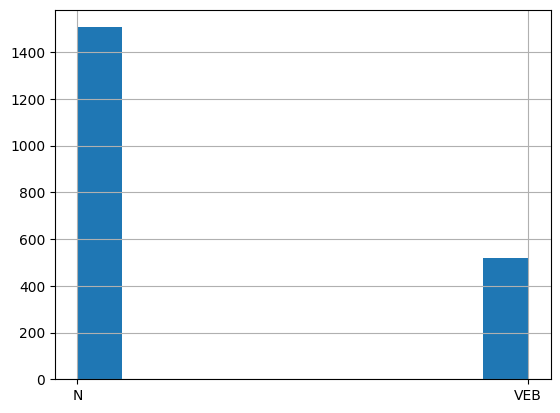

In [23]:
df['type'].hist()

## Making outputs

In [24]:
df['type'] = df["type"].map({
    "N": [1, 0, 0, 0, 0],
    "Q": [0, 1, 0, 0, 0],
    "SVEB": [0, 0, 1, 0, 0],
    "VEB": [0, 0, 0, 1, 0],
    "F": [0, 0, 0, 0, 1]
})

## Making x, y

In [25]:
x = df[["0_pre-RR" ,"0_qrs_interval"]]
y = np.array(df["type"].tolist())

In [26]:
x = (x - x.mean()) / x.std()

## Splitting data for training and testing

In [27]:
from sklearn.model_selection import train_test_split
import torch

x = torch.from_numpy(x.values).float()
y = torch.from_numpy(y).float()

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, random_state=1
)

In [28]:
x_train, y_train

(tensor([[ 1.0053, -0.6804],
         [-0.1422, -0.9999],
         [-1.2586,  1.8754],
         ...,
         [-1.3620,  2.0352],
         [ 0.4368, -0.4142],
         [ 0.1370, -0.9467]]),
 tensor([[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]))

## Arrhythmia Classifier

In [29]:
import torch.nn as nn


class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(model_structure[0], model_structure[1])
        self.act = nn.ReLU()
        self.output = nn.Linear(model_structure[1], model_structure[2])

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden): Linear(in_features=2, out_features=7, bias=True)
  (act): ReLU()
  (output): Linear(in_features=7, out_features=5, bias=True)
)

In [30]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
random.seed(10)

In [31]:
import torch
import tqdm
import copy

batches_per_epoch = len(x_train) // batch_size

best_acc = -np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = x_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            #  TODO remove error here

            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(x_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 709/709 [00:02<00:00, 326.83batch/s, acc=1, loss=0.000899]


Epoch 0 validation: Cross-entropy=0.06146697700023651, Accuracy=0.9621710777282715


Epoch 1: 100%|██████████| 709/709 [00:02<00:00, 247.57batch/s, acc=1, loss=0.00012] 


Epoch 1 validation: Cross-entropy=0.04841405898332596, Accuracy=0.9638158082962036


Epoch 2: 100%|██████████| 709/709 [00:02<00:00, 288.47batch/s, acc=1, loss=1.72e-5] 


Epoch 2 validation: Cross-entropy=0.04875466972589493, Accuracy=0.9703947305679321


Epoch 3: 100%|██████████| 709/709 [00:02<00:00, 293.35batch/s, acc=1, loss=5.07e-6] 


Epoch 3 validation: Cross-entropy=0.04385235905647278, Accuracy=0.96875


Epoch 4: 100%|██████████| 709/709 [00:02<00:00, 288.39batch/s, acc=1, loss=1.73e-6] 


Epoch 4 validation: Cross-entropy=0.034940630197525024, Accuracy=0.9802631735801697


Epoch 5: 100%|██████████| 709/709 [00:02<00:00, 290.45batch/s, acc=1, loss=4.77e-7] 


Epoch 5 validation: Cross-entropy=0.03283723071217537, Accuracy=0.9868420958518982


Epoch 6: 100%|██████████| 709/709 [00:02<00:00, 306.80batch/s, acc=1, loss=1.79e-7] 


Epoch 6 validation: Cross-entropy=0.03090173937380314, Accuracy=0.9901315569877625


Epoch 7: 100%|██████████| 709/709 [00:02<00:00, 309.43batch/s, acc=1, loss=5.96e-8] 


Epoch 7 validation: Cross-entropy=0.029178041964769363, Accuracy=0.9868420958518982


Epoch 8: 100%|██████████| 709/709 [00:02<00:00, 302.23batch/s, acc=1, loss=5.96e-8] 


Epoch 8 validation: Cross-entropy=0.027740202844142914, Accuracy=0.9851973652839661


Epoch 9: 100%|██████████| 709/709 [00:02<00:00, 299.44batch/s, acc=1, loss=-]       


Epoch 9 validation: Cross-entropy=0.026225024834275246, Accuracy=0.9851973652839661


Epoch 10: 100%|██████████| 709/709 [00:02<00:00, 279.17batch/s, acc=1, loss=-]       


Epoch 10 validation: Cross-entropy=0.029184268787503242, Accuracy=0.9868420958518982


Epoch 11: 100%|██████████| 709/709 [00:02<00:00, 300.45batch/s, acc=1, loss=-]       


Epoch 11 validation: Cross-entropy=0.027795499190688133, Accuracy=0.9868420958518982


Epoch 12: 100%|██████████| 709/709 [00:02<00:00, 313.88batch/s, acc=1, loss=-]       


Epoch 12 validation: Cross-entropy=0.027701638638973236, Accuracy=0.9868420958518982


Epoch 13: 100%|██████████| 709/709 [00:02<00:00, 300.42batch/s, acc=1, loss=-]       


Epoch 13 validation: Cross-entropy=0.02711287885904312, Accuracy=0.9868420958518982


Epoch 14: 100%|██████████| 709/709 [00:02<00:00, 298.71batch/s, acc=1, loss=-]       


Epoch 14 validation: Cross-entropy=0.02622135914862156, Accuracy=0.9868420958518982


Epoch 15: 100%|██████████| 709/709 [00:02<00:00, 301.19batch/s, acc=1, loss=-]       


Epoch 15 validation: Cross-entropy=0.025464529171586037, Accuracy=0.9868420958518982


Epoch 16: 100%|██████████| 709/709 [00:02<00:00, 277.72batch/s, acc=1, loss=-]       


Epoch 16 validation: Cross-entropy=0.023351557552814484, Accuracy=0.9868420958518982


Epoch 17: 100%|██████████| 709/709 [00:02<00:00, 313.56batch/s, acc=1, loss=-]       


Epoch 17 validation: Cross-entropy=0.024190541356801987, Accuracy=0.9868420958518982


Epoch 18: 100%|██████████| 709/709 [00:02<00:00, 300.49batch/s, acc=1, loss=-]       


Epoch 18 validation: Cross-entropy=0.024930957704782486, Accuracy=0.9868420958518982


Epoch 19: 100%|██████████| 709/709 [00:02<00:00, 303.91batch/s, acc=1, loss=-]       


Epoch 19 validation: Cross-entropy=0.022728487849235535, Accuracy=0.9868420958518982


Epoch 20: 100%|██████████| 709/709 [00:02<00:00, 294.15batch/s, acc=1, loss=-]       


Epoch 20 validation: Cross-entropy=0.024057645350694656, Accuracy=0.9868420958518982


Epoch 21: 100%|██████████| 709/709 [00:02<00:00, 310.67batch/s, acc=1, loss=-]       


Epoch 21 validation: Cross-entropy=0.02217913046479225, Accuracy=0.9868420958518982


Epoch 22: 100%|██████████| 709/709 [00:02<00:00, 318.17batch/s, acc=1, loss=-]       


Epoch 22 validation: Cross-entropy=0.023384282365441322, Accuracy=0.9884868264198303


Epoch 23: 100%|██████████| 709/709 [00:02<00:00, 286.92batch/s, acc=1, loss=-]       


Epoch 23 validation: Cross-entropy=0.021856291219592094, Accuracy=0.9884868264198303


Epoch 24: 100%|██████████| 709/709 [00:02<00:00, 279.56batch/s, acc=1, loss=-]       


Epoch 24 validation: Cross-entropy=0.023159576579928398, Accuracy=0.9884868264198303


Epoch 25: 100%|██████████| 709/709 [00:02<00:00, 322.41batch/s, acc=1, loss=-]       


Epoch 25 validation: Cross-entropy=0.0213470496237278, Accuracy=0.9884868264198303


Epoch 26: 100%|██████████| 709/709 [00:02<00:00, 342.77batch/s, acc=1, loss=-]       


Epoch 26 validation: Cross-entropy=0.02247634157538414, Accuracy=0.9884868264198303


Epoch 27: 100%|██████████| 709/709 [00:02<00:00, 344.82batch/s, acc=1, loss=-]       


Epoch 27 validation: Cross-entropy=0.020641496405005455, Accuracy=0.9884868264198303


Epoch 28: 100%|██████████| 709/709 [00:01<00:00, 359.52batch/s, acc=1, loss=-]       


Epoch 28 validation: Cross-entropy=0.02240103669464588, Accuracy=0.9884868264198303


Epoch 29: 100%|██████████| 709/709 [00:02<00:00, 311.56batch/s, acc=1, loss=-]       


Epoch 29 validation: Cross-entropy=0.02040933258831501, Accuracy=0.9884868264198303


Epoch 30: 100%|██████████| 709/709 [00:02<00:00, 343.64batch/s, acc=1, loss=-]       


Epoch 30 validation: Cross-entropy=0.02165290154516697, Accuracy=0.9884868264198303


Epoch 31: 100%|██████████| 709/709 [00:02<00:00, 319.60batch/s, acc=1, loss=-]       


Epoch 31 validation: Cross-entropy=0.021309027448296547, Accuracy=0.9884868264198303


Epoch 32: 100%|██████████| 709/709 [00:02<00:00, 346.17batch/s, acc=1, loss=-]       


Epoch 32 validation: Cross-entropy=0.02253475971519947, Accuracy=0.9884868264198303


Epoch 33: 100%|██████████| 709/709 [00:02<00:00, 330.38batch/s, acc=1, loss=-]       


Epoch 33 validation: Cross-entropy=0.021299976855516434, Accuracy=0.9884868264198303


Epoch 34: 100%|██████████| 709/709 [00:02<00:00, 289.05batch/s, acc=1, loss=-]       


Epoch 34 validation: Cross-entropy=0.02145748771727085, Accuracy=0.9884868264198303


Epoch 35: 100%|██████████| 709/709 [00:01<00:00, 399.77batch/s, acc=1, loss=-]       


Epoch 35 validation: Cross-entropy=0.021121177822351456, Accuracy=0.9884868264198303


Epoch 36: 100%|██████████| 709/709 [00:02<00:00, 294.79batch/s, acc=1, loss=-]       


Epoch 36 validation: Cross-entropy=0.020297911018133163, Accuracy=0.9901315569877625


Epoch 37: 100%|██████████| 709/709 [00:02<00:00, 332.50batch/s, acc=1, loss=-]       


Epoch 37 validation: Cross-entropy=0.019667213782668114, Accuracy=0.9884868264198303


Epoch 38: 100%|██████████| 709/709 [00:02<00:00, 340.36batch/s, acc=1, loss=-]       


Epoch 38 validation: Cross-entropy=0.02114132232964039, Accuracy=0.9884868264198303


Epoch 39: 100%|██████████| 709/709 [00:02<00:00, 300.34batch/s, acc=1, loss=-]       


Epoch 39 validation: Cross-entropy=0.02010100521147251, Accuracy=0.9884868264198303


Epoch 40: 100%|██████████| 709/709 [00:02<00:00, 311.52batch/s, acc=1, loss=-]       


Epoch 40 validation: Cross-entropy=0.0203781146556139, Accuracy=0.9901315569877625


Epoch 41: 100%|██████████| 709/709 [00:02<00:00, 339.83batch/s, acc=1, loss=-]       


Epoch 41 validation: Cross-entropy=0.02192024327814579, Accuracy=0.9884868264198303


Epoch 42: 100%|██████████| 709/709 [00:02<00:00, 345.09batch/s, acc=1, loss=-]       


Epoch 42 validation: Cross-entropy=0.019788073375821114, Accuracy=0.9884868264198303


Epoch 43: 100%|██████████| 709/709 [00:02<00:00, 283.63batch/s, acc=1, loss=-]       


Epoch 43 validation: Cross-entropy=0.02001076377928257, Accuracy=0.9884868264198303


Epoch 44: 100%|██████████| 709/709 [00:02<00:00, 288.40batch/s, acc=1, loss=-]       

Epoch 44 validation: Cross-entropy=0.021111365407705307, Accuracy=0.9884868264198303


<All keys matched successfully>

## Plotting Cross entropy and accuracy

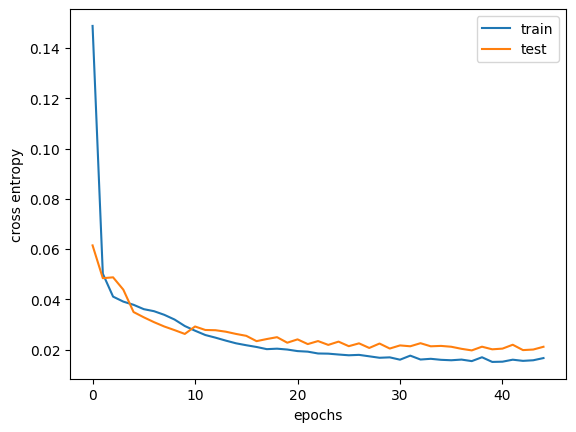

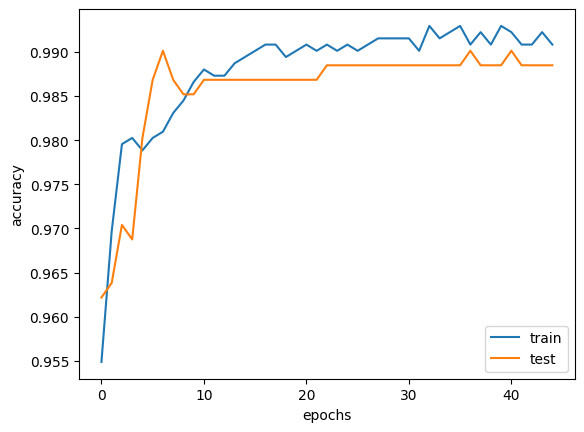

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()